## k-means

Pour tenter de résoudre notre problématique de cluestering nous pouvons utiliser l'algorithme de cluestering k-means.
Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes (ou clusters). Il minimise la somme des variances intra-cluster.

In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traitement les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

# permet d'afficher toutes les colonnes
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../Data/2.RFM_dataset.csv')
df = df.drop(columns='Monetary_bis')
df

,customer_unique_id,Recency,Frequency,Monetary
0,7c396fd4830fd04220f754e42b4e5bff,27.289810,2,1.303348
1,af07308b275d755c9edb36a90c618231,14.162002,1,1.601216
2,3a653a41f6f9fc3d2a113cf8398680e8,13.051752,1,1.647432
3,7c142cf63193a1473d2e66489a9ae977,25.737451,1,1.457031
4,72632f0f9dd73dfee390c9b22eb56dd6,22.505471,1,1.220373
...,...,...,...,...
96091,6359f309b166b0196dbf7ad2ac62bb5a,33.093157,1,1.494089
96092,da62f9e57a76d978d02ab5362c509660,22.786720,1,1.663569
96093,737520a9aad80b3fbbdad19b66b37b30,28.407875,1,1.723809
96094,5097a5312c8b157bb7be58ae360ef43c,23.908753,1,1.686544


Pour simplifier notre étude sur le nombre de cluster que nous allons créer, nous pouvons effectuer un échantillonnage de nos données afin d'optimiser les test de clustering.

In [3]:
df_sample = df.sample(10000, replace=False)
df_sample.shape

(10000, 4)

In [4]:
X = df_sample.drop('customer_unique_id', axis=1).values
y = df_sample['customer_unique_id'].values
print(X.shape)
print(y.shape)

(10000, 3)
(10000,)


In [5]:
from sklearn import preprocessing

X_norm = preprocessing.scale(X)
print(X_norm.shape)

(10000, 3)


Nous étudions le silhouette score pour différentes possibilitées de clustering, de 2 à 10. 
Le silhouette score est une métrique utilisée pour évaluer la qualité d'un clustering. Il mesure à quel point les clusters sont bien séparés les uns des autres. Un silhouette score plus élevé indique les clusters sont mieux définis.

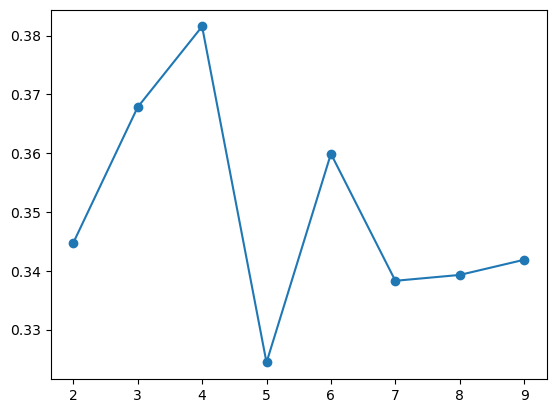

In [8]:
from sklearn import cluster, metrics

silhouettes = []

# on regarde de 2 à 10 clusters
for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=1, init='random')
    cls.fit(X_norm)
    silh = metrics.silhouette_score(X_norm, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

Nous créons des composantes principales qui synthètisent nos données en deux variables nous permettant d'avoir une visualisation graphique du clustering de nos données en 2D.

In [9]:
from sklearn import decomposition

X = df.drop('customer_unique_id', axis=1).values
X_norm = preprocessing.scale(X)

pca = decomposition.PCA(n_components=2)
pca.fit(X_norm)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(X_norm)

[0.34432841 0.68471856]


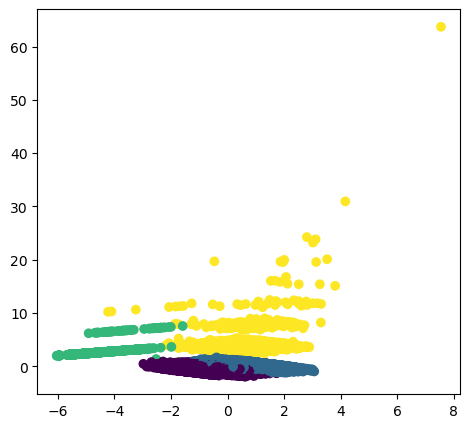

In [10]:
fig = plt.figure(figsize=(12, 5))

cls = cluster.KMeans(n_clusters=4)
cls.fit(X_norm)

# 1 figure en ordonné, 2 figures en abscisse
# et on s'occupe de la première figure
ax = fig.add_subplot(121)

# on observe la première et la deuxième composante
ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls.labels_)

Pour déterminer le nombre optimal de cluster à utiliser pour notre algorithme k-means nous utilisons la méthode du coude (Elbow Method), Elle consiste à observer la variation de l'inertie (somme des carrés des distances entre les points et les centroïdes) en fonction du nombre de clusters.  En examinant le graphique, nous cherchons un point où l'inertie intra-cluster commence à diminuer de manière significativement plus lente. Cela ressemble à la courbure d'un "coude". Le point où cette décélération devient notable est souvent interprété comme le nombre optimal de clusters.

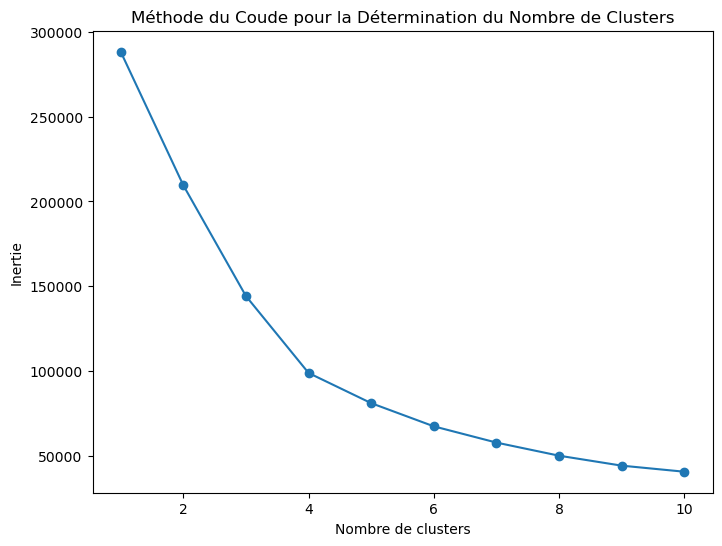

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_Y = df.drop('customer_unique_id', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_Y)

inertis = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_features)
    inertis.append(kmeans.inertia_)

# Tracé de la courbe de l'inertie
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertis, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour la Détermination du Nombre de Clusters')
plt.show()

Nous pouvons également utiliser le coefficient de distortion pour obtenir le k le plus adapté à notre modèle. Connu sous le nom d'inertie intra-classe, c'est une mesure qui évalue la compacité des clusters obtenus lors de l'application d'un algorithme de clustering comme K-means. Il mesure la somme des carrés des distances euclidiennes entre chaque point de données et le centroïde de son cluster associé. Nous cherchons souvent à trouver le nombre de clusters qui réduit le coefficient de distortion de manière significative, avant que la réduction devienne moins significative cette méthode est semblable à la méthode du coude.

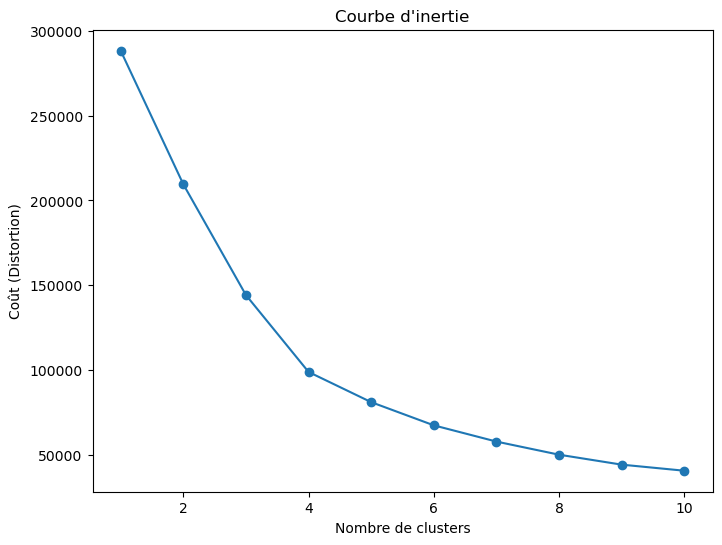

In [12]:
df_X = df.drop('customer_unique_id', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_X)

distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût (Distortion)')
plt.title("Courbe d'inertie")
plt.show()

In [13]:
import time

kmeans = KMeans(n_clusters=4)
scoring_time_start = time.time()
kmeans.fit(scaled_features)
scoring_time_end = time.time()

In [14]:
df['Cluster'] = kmeans.labels_
df

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,7c396fd4830fd04220f754e42b4e5bff,27.289810,2,1.303348,0
1,af07308b275d755c9edb36a90c618231,14.162002,1,1.601216,2
2,3a653a41f6f9fc3d2a113cf8398680e8,13.051752,1,1.647432,2
3,7c142cf63193a1473d2e66489a9ae977,25.737451,1,1.457031,1
4,72632f0f9dd73dfee390c9b22eb56dd6,22.505471,1,1.220373,2
...,...,...,...,...,...
96091,6359f309b166b0196dbf7ad2ac62bb5a,33.093157,1,1.494089,1
96092,da62f9e57a76d978d02ab5362c509660,22.786720,1,1.663569,2
96093,737520a9aad80b3fbbdad19b66b37b30,28.407875,1,1.723809,1
96094,5097a5312c8b157bb7be58ae360ef43c,23.908753,1,1.686544,1


Nous pouvons par la suite agréger les différents cluster observés aux différents individus et les observer graphiquement. Le nombre de variable de la segmentation RFM étant au nombre de 3 nous effectuons une visualisation graphique en 3D.

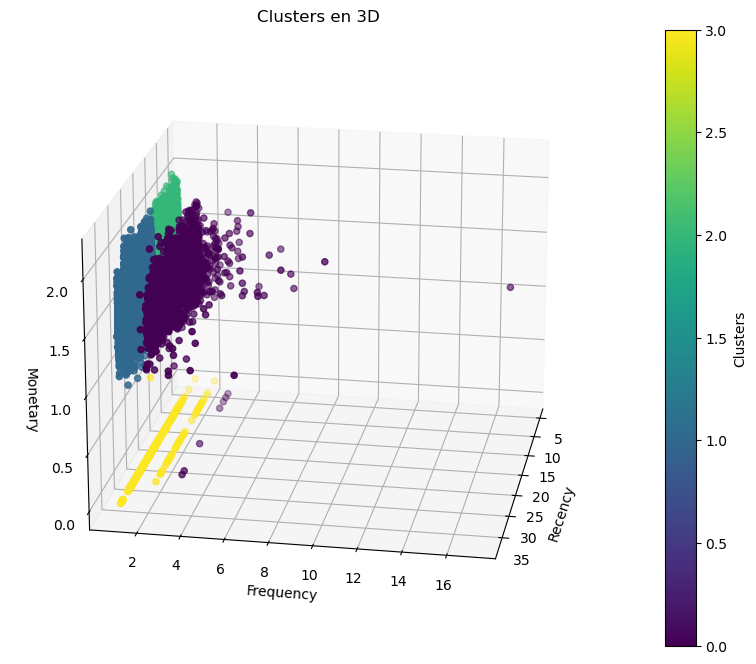

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['Recency'],
                     df['Frequency'],
                     df['Monetary'], c=df['Cluster'], cmap='viridis')

fig.colorbar(scatter, ax=ax, label='Clusters')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.view_init(azim=10, elev=20)

plt.title('Clusters en 3D')
plt.show()

In [16]:
df_cluster = df.copy()
df = pd.read_csv('../Data/2.RFM_dataset.csv')
df_cluster['Monetary_bis'] = df['Monetary_bis']
df_cluster

,customer_unique_id,Recency,Frequency,Monetary,Cluster,Monetary_bis
0,7c396fd4830fd04220f754e42b4e5bff,27.289810,2,1.303348,0,38.71
1,af07308b275d755c9edb36a90c618231,14.162002,1,1.601216,2,141.46
2,3a653a41f6f9fc3d2a113cf8398680e8,13.051752,1,1.647432,2,179.12
3,7c142cf63193a1473d2e66489a9ae977,25.737451,1,1.457031,1,72.20
4,72632f0f9dd73dfee390c9b22eb56dd6,22.505471,1,1.220373,2,28.62
...,...,...,...,...,...,...
96091,6359f309b166b0196dbf7ad2ac62bb5a,33.093157,1,1.494089,1,85.08
96092,da62f9e57a76d978d02ab5362c509660,22.786720,1,1.663569,2,195.00
96093,737520a9aad80b3fbbdad19b66b37b30,28.407875,1,1.723809,1,271.01
96094,5097a5312c8b157bb7be58ae360ef43c,23.908753,1,1.686544,1,220.58


In [17]:
cluster_dataset = '../Data/3.K_means_clusters.csv'
df_cluster.to_csv(cluster_dataset, index=False)

Cette étape nous permet d'évaluer la pertinence du modèle en réalisant une étude de sa performance avec différentes métriques.
 - Un métric de temps de calcul du modèle de ML.
 - Le silhouette score
 - le coefficient de distortion
 - Davies Bouldin (mesure à quel point les clusters sont compacts et bien séparés les uns des autres.)

In [18]:
from sklearn.metrics import davies_bouldin_score

duration_time = scoring_time_end - scoring_time_start
silh_score = metrics.silhouette_score(scaled_features, kmeans.labels_)
db_score = davies_bouldin_score(scaled_features, kmeans.labels_)

In [20]:
import sys
sys.path.append('..')

In [21]:
from PythonFiles.Utils2 import *

In [22]:
CreateScoreTab()

In [23]:
resultats_modele1 = scoring_function('k_means',
                                     duration_time,
                                     silh_score,
                                     kmeans.inertia_,
                                     db_score)
resultats_modele1

,Model_name,Time,Silhouette_score,Coef_distortion,Davies-bouldin
0,k_means,0.318596,0.408218,98799.913722,0.686319


In [24]:
AllScore_function(resultats_modele1)

In [25]:
df_testx = pd.read_csv('../Data/0.global_scoring.csv')
df_testx

,Unnamed: 0,Model_name,Time,Silhouette_score,Coef_distortion,Davies-bouldin
0,NaN,k_means,0.318596,0.408218,98799.913722,0.686319
